#Load Libraries

In [45]:
import os
import numpy as np
import cv2
import tensorflow as tf #for deep learning framework
tf.compat.v1.executing_eagerly_outside_functions
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,Conv2DTranspose,Dropout,SeparableConv2D, Dropout, UpSampling2D, concatenate #for convolutional layers, max pooling, upsampling and concatenation of layers
from tensorflow.keras.models import Model #for model creation
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator #for image data augmentation
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras import backend as b
from matplotlib import pyplot as plt
from tqdm import tqdm

# Function to load and preprocess data

In [4]:

def load_data(img_folder, mask_folder):
    img_path = os.path.join(img_folder)
    mask_path = os.path.join(mask_folder)

    images = []
    masks = []
    print("number of image in DS b/re processing: ", len(os.listdir(img_path)))
    print("number of mask in DS b/re processing: ", len(os.listdir(mask_path)))
    #for img_filename in os.listdir(img_path):
    for img_filename in tqdm(os.listdir(img_path)):
        mask_filename = img_filename.split('.')[0] + '_mask.png' # Get the mask filename corresponding to the image
        #program to check if mask_filename founds in masks folder
        if mask_filename not in os.listdir(mask_path):
            continue
        img = cv2.imread(os.path.join(img_path, img_filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))  # Adjust size as needed
        images.append(img)

        mask = cv2.imread(os.path.join(mask_path, mask_filename), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256, 256))  # Adjust size as needed
        masks.append(mask)

    return np.array(images), np.array(masks)

#Define the similarity metrics

In [5]:
def dice_coefficient(y_true, y_pred):
    y_true_f = b.flatten(y_true)
    y_pred_f = b.flatten(y_pred)
    intersection = b.sum(y_true_f * y_pred_f)
    return (2 * intersection+1) / (b.sum(y_true_f) + b.sum(y_pred_f) + 1)

def jaccard_index(y_true, y_pred):
    y_true_f = b.flatten(y_true)
    y_pred_f = b.flatten(y_pred)
    intersection = b.sum(y_true_f * y_pred_f)
    jac_idx = intersection  / (b.sum(y_true_f) + b.sum(y_pred_f) - intersection + 1e-2 )

    return jac_idx

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coefficient(y_true, y_pred)

# Build U-Net model

In [6]:
def unet_model():
    inputs = layers.Input(shape=(256, 256, 3))
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottom of the U
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Expansive Path (Decoder)
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = concatenate([up5, conv3], axis=-1)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv2], axis=-1)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv1], axis=-1)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

# Load and preprocess data

In [7]:

img_folder = '/content/drive/MyDrive/Dataset/CXR_png/'
mask_folder = '/content/drive/MyDrive/Dataset/masks/'
images, masks = load_data(img_folder, mask_folder)
print('Loading complete!')
print('Image dataset shape: ', images.shape)
print('Mask dataset shape: ', masks.shape)

number of image in DS b/re processing:  800
number of mask in DS b/re processing:  704


100%|██████████| 800/800 [01:44<00:00,  7.68it/s] 


Loading complete!
Image dataset shape:  (566, 256, 256, 3)
Mask dataset shape:  (566, 256, 256)


## Normalize images and masks

In [8]:
images = images / 255.0
masks = masks / 255.0

# Split the Dataset into train and test set

In [9]:
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# Create U-Net model

In [10]:
model = unet_model()

In [11]:
# Define the path to save the best model weights
weight_path = "{}_weights.best.hdf5".format('cxr_reg')

# Callback to save the best model weights based on validation loss
checkpoint = ModelCheckpoint(
    weight_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=True
)

# Callback to reduce learning rate on plateau (if validation loss stops improving)
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    mode='min',
    epsilon=0.0001,
    cooldown=2,
    min_lr=1e-6
)

# Callback to stop training early if validation loss stops improving
early = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=15
)

# List of callbacks to be used during training
callbacks_list = [checkpoint, early, reduceLROnPlat]

#configure the learning process before training the model

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4), loss='binary_crossentropy', metrics=['accuracy',dice_coef_loss,dice_coefficient, jaccard_index])

# Train the model

In [13]:
history=model.fit(X_train, y_train, batch_size=32,epochs=20,validation_data=(X_val,y_val) ,callbacks=callbacks_list)

Epoch 1/20
15/15 [==============================] - ETA: 0s - loss: 0.6002 - accuracy: 0.7440 - dice_coef_loss: 0.7147 - dice_coefficient: 0.2853 - jaccard_index: 0.1669
Epoch 1: val_loss improved from inf to 0.55547, saving model to cxr_reg_weights.best.hdf5
15/15 [==============================] - 118s 4s/step - loss: 0.6002 - accuracy: 0.7440 - dice_coef_loss: 0.7147 - dice_coefficient: 0.2853 - jaccard_index: 0.1669 - val_loss: 0.5555 - val_accuracy: 0.7510 - val_dice_coef_loss: 0.7183 - val_dice_coefficient: 0.2817 - val_jaccard_index: 0.1640 - lr: 2.0000e-04
Epoch 2/20
15/15 [==============================] - ETA: 0s - loss: 0.4952 - accuracy: 0.7455 - dice_coef_loss: 0.6861 - dice_coefficient: 0.3139 - jaccard_index: 0.1871
Epoch 2: val_loss improved from 0.55547 to 0.41958, saving model to cxr_reg_weights.best.hdf5
15/15 [==============================] - 23s 2s/step - loss: 0.4952 - accuracy: 0.7455 - dice_coef_loss: 0.6861 - dice_coefficient: 0.3139 - jaccard_index: 0.1871 - 

# Save and display the trained model

In [14]:
model.save('/content/unet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

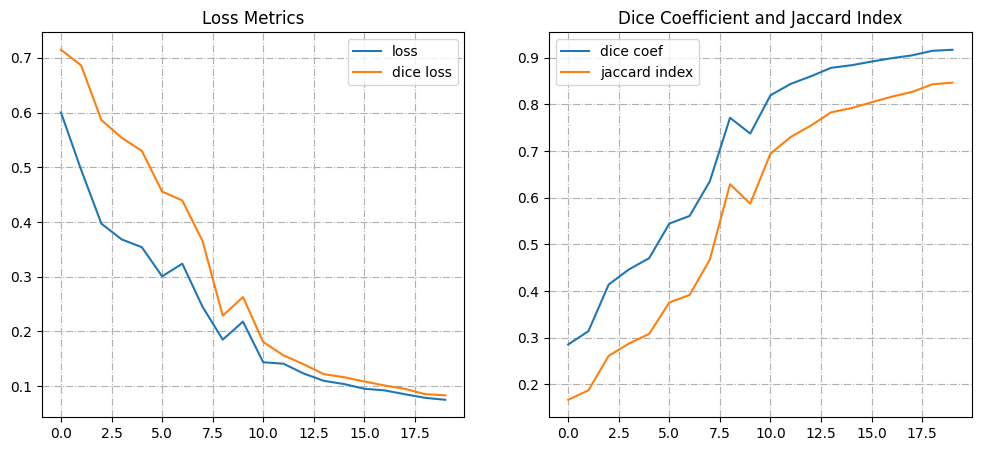

In [16]:
fig, axs = plt.subplots(1,2, figsize = (12,5), dpi = 100)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Loss Metrics")
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['dice_coef_loss'])
axs[0].legend(["loss", "dice loss"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Dice Coefficient and Jaccard Index")
axs[1].plot(history.history['dice_coefficient'])
axs[1].plot(history.history['jaccard_index'])
axs[1].legend(['dice coef', 'jaccard index'])

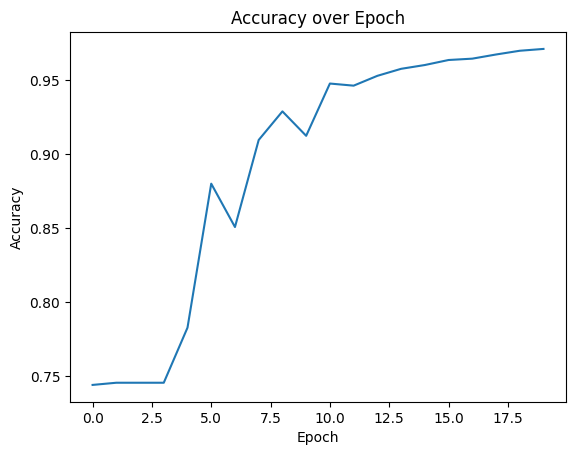

In [20]:
plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epoch')
plt.show()

In [28]:
max_accuracy = max(history.history['accuracy'])
max_accuracy = round(max_accuracy, 2)
print("Training Accuracy: ",max_accuracy)

Training Accuracy:  0.97


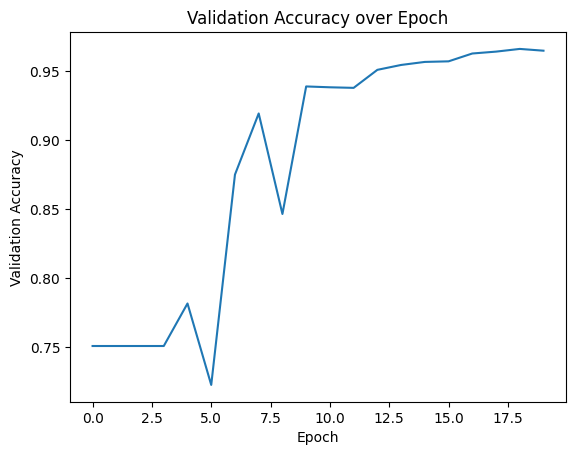

In [21]:
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over Epoch')
plt.show()

In [30]:
max_val_accuracy = max(history.history['val_accuracy'])
max_val_accuracy = round(max_val_accuracy, 2)
print("Training Validation Accuracy: ",max_val_accuracy)

Training Validation Accuracy:  0.97


(1, 256, 256, 3)
1/1 [==============================] - 0s 38ms/step


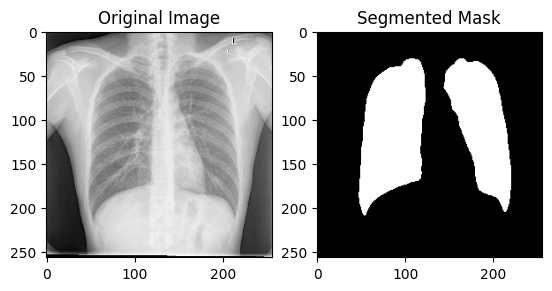

In [44]:
# Load the image
image =cv2.imread('/content/drive/MyDrive/Dataset/test/CHNCXR_0025_0.png')

# Preprocess the image as above
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (256, 256))
image = np.array(image)
image = image / 255.0
image = np.reshape(image, (1, 256, 256, 3))
print(image.shape)
segmented_image = model.predict(image)
# Threshold the mask
threshold = 0.5
segmented_mask_binary = (segmented_image > threshold).astype(np.uint8)

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(image.reshape(256, 256, 3))
plt.title('Original Image')

# Display the segmented mask
plt.subplot(1, 2, 2)
plt.imshow(segmented_mask_binary.reshape(256, 256), cmap='gray')
plt.title('Segmented Mask')

plt.show()

